In [1]:
"""
A simple example of how to train a predictive time-series model with CRBM

Created by Omid Alemi
"""

%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image
from IPython import display

import numpy as np
import tensorflow as tf
import sys
sys.path.append('../')

from xrbm.models.crbm import CRBM
from xrbm.utils.vizutils import tile_raster_images

/home/omid/anaconda2/envs/tfconda35/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [9]:
 # Set up the parameters
snapshot_dir = './logs/'
snapshot_freq = 0
num_vis = 4
num_hid = 300
timesteps = 10
batch_size=100
cd_k=1
wdecay=0.0002
activation=tf.nn.sigmoid
initializer=tf.contrib.layers.xavier_initializer()
#initializer=tf.contrib.layers.variance_scaling_initializer()
vis_type='gaussian'

In [10]:
# Create some toy sequences with sin waves

FREQS = [30, 40, 50, 60]
AMPS = [3, 1, 0.4, 1.5]
NSAMPLE = 700
SEQ_LEN = 600

time_data = np.arange(SEQ_LEN) / 200

X_data = []

print('Making dummy time series...')
for i in range(NSAMPLE):
    r_data = np.float32(np.random.rand(SEQ_LEN, num_vis)) / 20 # random noise
    x = np.asarray([np.float32(np.sin(FREQS[d] * time_data + np.random.rand()) * (AMPS[d]+np.random.rand()/20)) for d in range(num_vis)]).T
    x = np.asarray([d + np.random.rand()/10 for d in x])
    X_data.append(x)

X_data = np.asarray(X_data)

X_data_flat = np.concatenate([m for m in X_data], axis=0)

data_mean = np.mean(X_data_flat, axis=0)
data_std = np.std(X_data_flat, axis=0)

X_data_normalized = [(d - data_mean) / data_std for d in X_data]

def makeSeqHistory(seqs, order, step=1):
    history = []
    outputs = []
    for m in seqs:
        for i in range(0, len(m)-order, step):
            history.append(m[i:i+order].flatten())
            outputs.append(m[i+order])

    return np.asarray(history), np.asarray(outputs)


# cond_data, visible_data = makeSeqHistory(X_data, timesteps)
cond_data, visible_data = makeSeqHistory(X_data_normalized, timesteps)

num_cond = cond_data[0].shape[0]
print('Done!')

Making dummy time series...
Done!


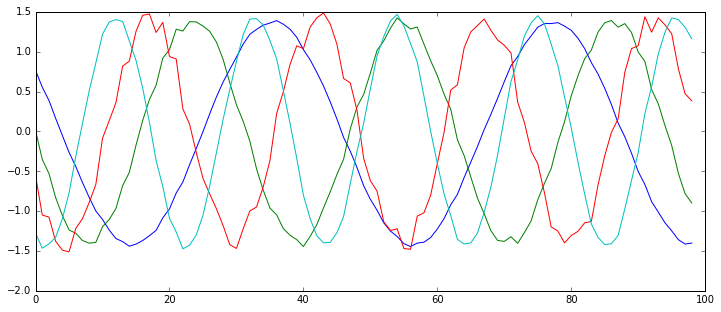

In [11]:
_=plt.figure(figsize=(12,5))
_=plt.plot(visible_data[1:100,:])

In [12]:
#_=plt.figure(figsize=(12,5))
#_=plt.plot(np.asarray(X_data_normalized)[1:10,:,0])

In [13]:
def generate():
    gen_sample = []
    gen_hidden = []
    initcond = []

    gen_init_frame = 100
    num_gen = 200

    for f in range(timesteps):
        gen_sample.append(np.reshape(visible_data[gen_init_frame+f], [1, num_vis]))

    # gen_cond = deque(test_cond[gen_init_frame])
    # gen_init = test_input[gen_init_frame-1] + 0.01 * np.random.randn(1, num_vis)

    print('Generating %d frames: '%(num_gen))

    for f in range(num_gen):
        initcond = np.asarray([gen_sample[s] for s in range(f,f+timesteps)]).ravel()
        # initcond = np.asarray([test_input[s+gen_init_frame] for s in range(f,f+timesteps)]).ravel()

        initframes = gen_sample[f+timesteps-1] # + 0.01 * np.random.randn(1, num_vis)

        s, h = sess.run(gen_op, feed_dict={gen_cond: np.reshape(initcond, [1,num_cond]).astype(np.float32),
                                           gen_init: initframes })

        gen_sample.append(s)
        gen_hidden.append(h)

    gen_sample = np.reshape(np.asarray(gen_sample), [num_gen+timesteps,num_vis])

    gen_sample = gen_sample * data_std + data_mean

    fig=fig = plt.figure(figsize=(12, 5))
    _=plt.plot(gen_sample[0:70,:])
    display.display(fig)

Epoch 1 / 5 | cost = -3.361730 | lr = 0.005000 | momentum = 0.000000 | sparse cost = 0.000000
Epoch 2 / 5 | cost = -3.314384 | lr = 0.005000 | momentum = 0.000000 | sparse cost = 0.000000
Epoch 3 / 5 | cost = -3.316198 | lr = 0.005000 | momentum = 0.000000 | sparse cost = 0.000000
Epoch 4 / 5 | cost = -3.314359 | lr = 0.005000 | momentum = 0.000000 | sparse cost = 0.000000
Epoch 5 / 5 | cost = -3.311716 | lr = 0.005000 | momentum = 0.000000 | sparse cost = 0.000000
Generating 200 frames: 


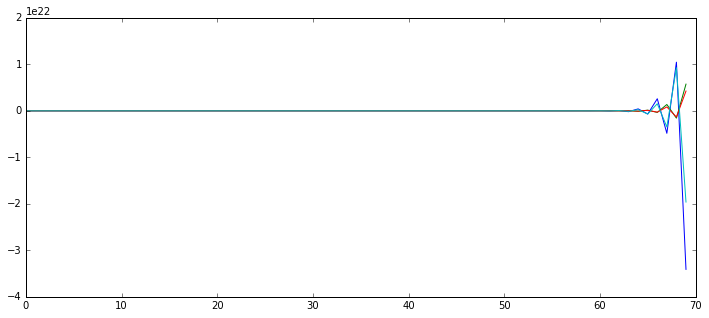

--------------------------------------------------------------------------------
Training gaussian CRBM with 300 <function sigmoid at 0x7f1535fc00d0> units
lr: 0.010, batchsize: 100, cd: 1, wdecay: 0.000200, mom: 0.9
--------------------------------------------------------------------------------
Model order: 10
Training data size: 413000 sequences of length 10
--------------------------------------------------------------------------------
Epoch 1 / 10 | cost = -3.304558 | lr = 0.005000 | momentum = 0.900000 | sparse cost = 0.000000
Epoch 2 / 10 | cost = -3.281885 | lr = 0.005000 | momentum = 0.900000 | sparse cost = 0.000000
Epoch 3 / 10 | cost = -3.268344 | lr = 0.005000 | momentum = 0.900000 | sparse cost = 0.000000
Epoch 4 / 10 | cost = -3.258705 | lr = 0.005000 | momentum = 0.900000 | sparse cost = 0.000000
Epoch 5 / 10 | cost = -3.251760 | lr = 0.005000 | momentum = 0.900000 | sparse cost = 0.000000


In [ ]:
tf.reset_default_graph()
c1 = CRBM(num_vis=num_vis, num_cond=num_cond, num_hid=num_hid, 
          vis_type=vis_type, 
          name='crbm_toy', 
          activation=activation,
          initializer=initializer)

gen_cond = tf.placeholder(tf.float32, shape=[1, cond_data.shape[1]], name='gen_cond_data')
gen_init = tf.placeholder(tf.float32, shape=[1, visible_data.shape[1]], name='gen_init_data')
gen_op = c1.make_prediction(gen_cond, gen_init, 60)

# Initialize the tf variables
init = tf.global_variables_initializer()

# Lunch the session
sess = tf.Session()
sess.run(init)

## Train
print('-'*80)
print('Training %s CRBM with %i %s units'%(vis_type, num_hid, activation))
print('lr: %1.3f, batchsize: %i, cd: %i, wdecay: %f, mom: %1.1f'%(learning_rate, batch_size, cd_k, wdecay, momentum))
# print('sparsity target: %1.4f, sparsity cost: %1.3f, sparse_decay %1.3f'%(sparse_target, sparse_cost, sparse_decay))
print('-'*80)
# print('Dataset: %s'%(mocdataset))
print('Model order: %i'%(timesteps))
print('Training data size: %s sequences of length %i'%(len(visible_data), timesteps))
print('-'*80)

## for first 6 epoches, don't use momentum
learning_rate = 0.005
momentum = 0
W, A, B, vb, hb = c1.train(sess,
         input_data=visible_data,
         cond_data=cond_data,
         training_epochs=5,
         learning_rate=learning_rate,
         batch_size=batch_size,
         cd_k=cd_k,
         wdecay=wdecay,
         momentum=momentum)


generate()
# now add the momentum for the rest of the training


momentum = 0.9
learning_rate = 0.005
W, A, B, vb, hb = c1.train(sess,
         input_data=visible_data,
         cond_data=cond_data,
         training_epochs=10,
         learning_rate=learning_rate,
         batch_size=batch_size,
         cd_k=cd_k,
         wdecay=wdecay,
         momentum=momentum)

generate()

learning_rate = 0.001

W, A, B, vb, hb = c1.train(sess,
         input_data=visible_data,
         cond_data=cond_data,
         training_epochs=10,
         learning_rate=learning_rate,
         batch_size=batch_size,
         cd_k=cd_k,
         wdecay=wdecay,
         momentum=momentum)

generate()

learning_rate = 0.001
W, A, B, vb, hb = c1.train(sess,
         input_data=visible_data,
         cond_data=cond_data,
         training_epochs=20,
         learning_rate=learning_rate,
         batch_size=batch_size,
         cd_k=cd_k,
         wdecay=wdecay,
         momentum=momentum)

generate()

W, A, B, vb, hb = c1.train(sess,
         input_data=visible_data,
         cond_data=cond_data,
         training_epochs=150,
         learning_rate=learning_rate,
         batch_size=batch_size,
         cd_k=cd_k,
         wdecay=wdecay,
         momentum=momentum)

generate()

In [ ]:
print(W.shape)
_=plt.figure(figsize=(12,2))
_=plt.imshow(W, interpolation='nearest', aspect='auto')

print(A.shape)
_=plt.figure(figsize=(12,2))
_=plt.imshow(A.T, interpolation='nearest', aspect='auto')

print(B.shape)
_=plt.figure(figsize=(10,3))
_=plt.imshow(B, interpolation='nearest', aspect='auto')

In [ ]:
######
# now let's generate somthing
gen_sample = []
gen_hidden = []
initcond = []

gen_init_frame = 100
num_gen = 1000

for f in range(timesteps):
    gen_sample.append(np.reshape(visible_data[gen_init_frame+f], [1, num_vis]))

# gen_cond = deque(test_cond[gen_init_frame])
# gen_init = test_input[gen_init_frame-1] + 0.01 * np.random.randn(1, num_vis)

print('Generating %d frames: '%(num_gen))

for f in range(num_gen):
    initcond = np.asarray([gen_sample[s] for s in range(f,f+timesteps)]).ravel()
    # initcond = np.asarray([test_input[s+gen_init_frame] for s in range(f,f+timesteps)]).ravel()

    initframes = gen_sample[f+timesteps-1] # + 0.01 * np.random.randn(1, num_vis)

    s, h = sess.run(gen_op, feed_dict={gen_cond: np.reshape(initcond, [1,num_cond]).astype(np.float32),
                                       gen_init: initframes })

    gen_sample.append(s)
    gen_hidden.append(h)

gen_sample = np.reshape(np.asarray(gen_sample), [num_gen+timesteps,num_vis])

gen_sample = gen_sample * data_std + data_mean

fig = plt.figure(figsize=(12, 5))
plt.plot(gen_sample[0:200,:])

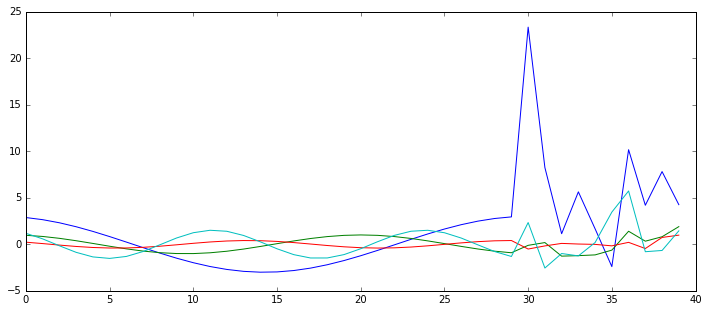

In [22]:
fig = plt.figure(figsize=(12, 5))
plt.plot(gen_sample[0:40,:])

(510, 4)


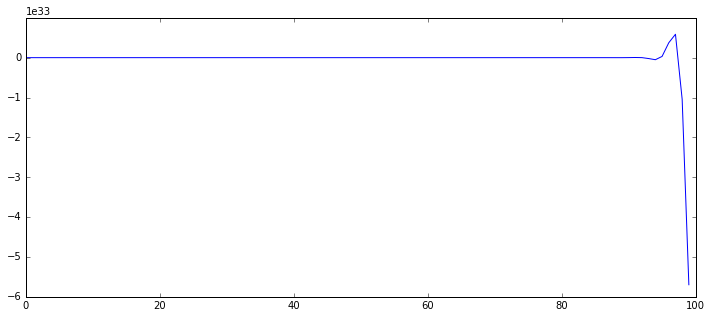

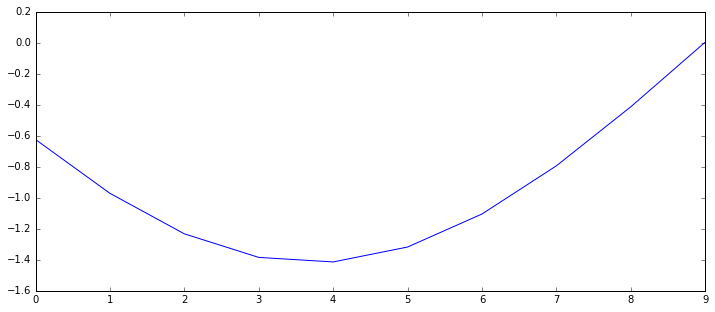

In [10]:
print(gen_sample.shape)
fig = plt.figure(figsize=(12, 5))
plt.plot(gen_sample[0:100,1])
fig = plt.figure(figsize=(12, 5))
plt.plot(visible_data[0:10,1])
